In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
google_apps = pd.read_csv('Google Play Store Apps.zip')
google_reviews = pd.read_csv('google_app_reviews.csv')

In [3]:
google_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312944 entries, 0 to 2312943
Data columns (total 24 columns):
App Name             object
App Id               object
Category             object
Rating               float64
Rating Count         float64
Installs             object
Minimum Installs     float64
Maximum Installs     int64
Free                 bool
Price                float64
Currency             object
Size                 object
Minimum Android      object
Developer Id         object
Developer Website    object
Developer Email      object
Released             object
Last Updated         object
Content Rating       object
Privacy Policy       object
Ad Supported         bool
In App Purchases     bool
Editors Choice       bool
Scraped Time         object
dtypes: bool(4), float64(4), int64(1), object(15)
memory usage: 361.8+ MB


In [4]:
google_apps.rename(columns={'App Id': 'app_id'}, inplace=True)

In [5]:
apps = google_apps.merge(google_reviews, on="app_id", how='inner')

In [6]:
apps = apps.groupby('app_id').mean()

In [7]:
apps = apps[apps['Rating'] > 0]

In [8]:
a2 = apps.copy()

In [30]:
apps['Rating'] = np.sqrt(apps['Rating'])

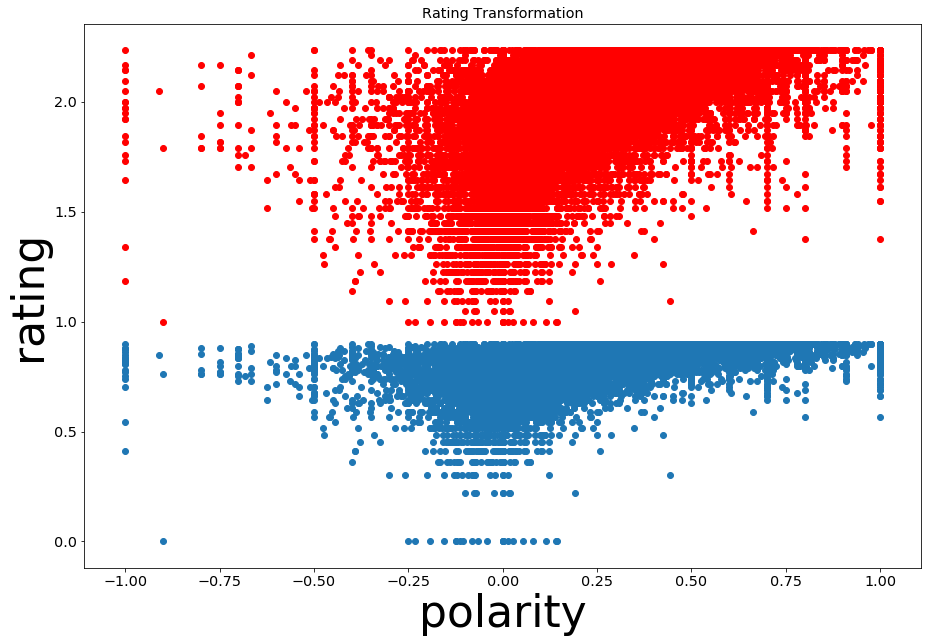

In [53]:
plt.rcParams.update({'axes.titlesize': 'x-large', 
                     'axes.labelsize': '44' })
plt.figure(figsize=(15,10))
plt.scatter(apps['polarity'], apps['Rating'], color='red')
plt.scatter(apps['polarity'], a2['Rating'])
plt.xlabel('polarity')
plt.ylabel('rating')
plt.title('Rating Transformation')
plt.show()

In [19]:
apps.columns

Index(['Rating', 'Rating Count', 'Minimum Installs', 'Maximum Installs',
       'Free', 'Price', 'Ad Supported', 'In App Purchases', 'Editors Choice',
       'Unnamed: 0', 'score', 'likes', 'polarity'],
      dtype='object')

In [31]:
features = ['Rating', 'polarity', 'Rating Count', 'Minimum Installs', 'Maximum Installs', 'Free', 'Price']
apps = apps[features]

KeyError: "['Minimum Installs', 'Maximum Installs'] not in index"

In [32]:
apps['installs'] = (apps['Minimum Installs'] + apps['Maximum Installs']) / 2
apps.drop(['Minimum Installs', 'Maximum Installs'], axis=1, inplace=True)
apps.head(10)

KeyError: 'Minimum Installs'

In [12]:
# apps.head()
# apps.shape
# apps.columns
# apps.info()
# apps.describe()
apps.corr()
# apps.dropna().shape
# apps[apps.isna().any(axis=1)]

,Rating,polarity,Rating Count,Free,Price,installs
Rating,1.000000,0.493591,0.023201,-0.062361,0.045104,0.019397
polarity,0.493591,1.000000,-0.028042,0.007907,-0.000756,-0.032809
Rating Count,0.023201,-0.028042,1.000000,0.003840,-0.001806,0.742463
Free,-0.062361,0.007907,0.003840,1.000000,-0.716347,0.009484
Price,0.045104,-0.000756,-0.001806,-0.716347,1.000000,-0.006786
installs,0.019397,-0.032809,0.742463,0.009484,-0.006786,1.000000


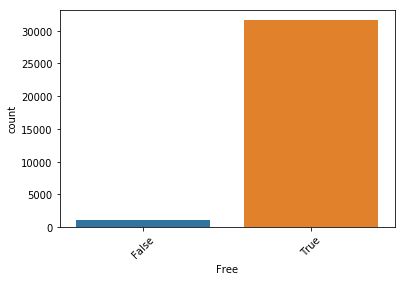

In [13]:
sns.countplot(x='Free', data=apps)
plt.rcParams["figure.figsize"] = (40,12)
plt.xticks(rotation=45) 
plt.show()

since most apps are free, we'll remove Free and Price columns

In [14]:
apps.drop(['Price', 'Free'], axis=1, inplace=True)

In [15]:
apps.head()

,Rating,polarity,Rating Count,installs
app_id,,,,
ac.lite,4.1,0.023030,16677.0,1931505.0
ad.RailWiki,5.0,0.517929,111.0,149.5
ad.my.plan,3.4,0.240000,14.0,5234.0
advenworks.com.snakeblast,3.8,0.020089,8191.0,503805.5
ae.ac.sharjah.UOSmobile,3.8,0.236684,17.0,2998.0


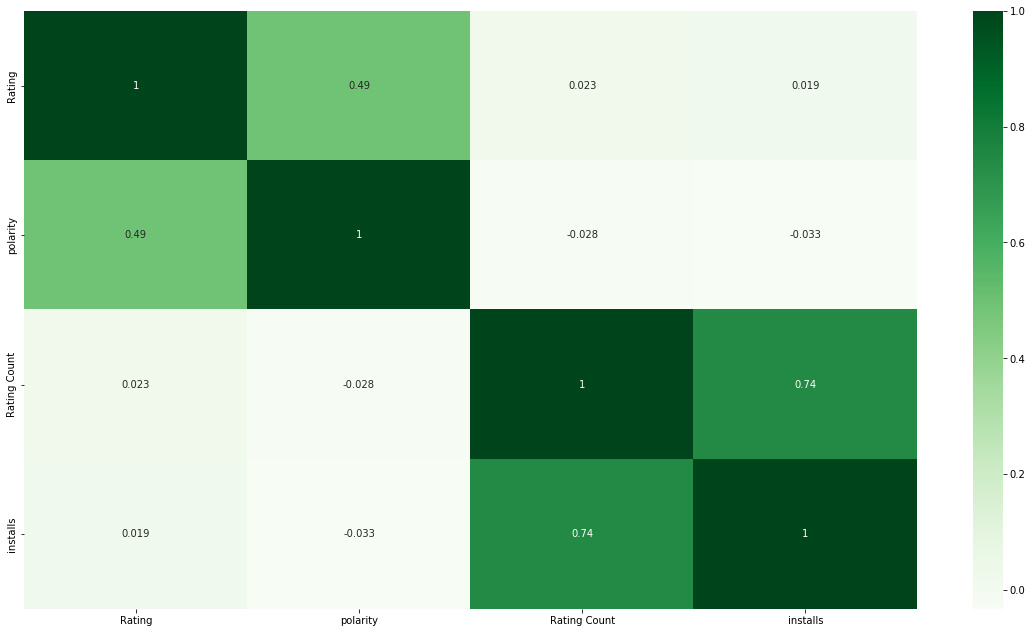

In [35]:
plt.figure(figsize=(20, 11))
cor = apps.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens)
plt.show()

# Select features and target

In [33]:
features = ['polarity', 'Rating Count', 'installs']
y = apps['Rating']
X = apps[features]

In [34]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)

# Decision Tree 🌲

In [35]:
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)


scores = {leaf_size: get_mae(leaf_size, train_X, val_X, train_y, val_y) for leaf_size in [14]}
# min(scores, key=scores.get)
scores

{14: 0.1236853133094602}

In [39]:
decision_tree = DecisionTreeRegressor(max_leaf_nodes=50, min_samples_split=100, min_samples_leaf=100, max_features=3)
decision_tree.fit(train_X, train_y)

val_predictions = decision_tree.predict(val_X)
print("MAE: ",mean_absolute_error(val_y, val_predictions))
print("Decision Tree Score: ", decision_tree.score(val_X, val_y))

MAE:  0.12010378523199049
Decision Tree Score:  0.392930384943395


# Random Forest 🌳🌳🌳🌳

In [40]:
forest_model = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(max_depth=15, n_estimators=100, min_samples_leaf=100, min_samples_split=500)
)

forest_model.fit(train_X, train_y)
forest_preds = forest_model.predict(val_X)
print("MAE: ",mean_absolute_error(val_y, forest_preds))
print("Random Forest Score: ", forest_model.score(val_X, val_y))

MAE:  0.11793176955058374
Random Forest Score:  0.4096689141310937


# K Nearest Neighbours

In [40]:
model = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=9)
)
model.fit(train_X, train_y)

print("MAE: ",mean_absolute_error(val_y, model.predict(val_X)))
print(model.score(val_X, val_y))

MAE:  0.4769626454378445
0.3470992842130002


# SVM

In [41]:
svm = make_pipeline(
    StandardScaler(), 
    SVR(C=1.0, epsilon=0.2)
)
svm.fit(train_X, train_y)

print("MAE: ",mean_absolute_error(val_y, model.predict(val_X)))
print("SVM Score: ", svm.score(val_X, val_y))

MAE:  0.4769626454378445
SVM Score:  0.33226986612456666


In [24]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVR(C=1.0, epsilon=0.2))])

pipe.fit(train_X, train_y)

pipe.score(train_X, train_y)

0.23578276727697686

# Google Playstore CSV

In [25]:
playstore = pd.read_csv('googleplaystore.csv')

In [26]:
(playstore.isnull().sum()/playstore.shape[0])*100

App                0.000000
Category           0.000000
Rating            13.596532
Reviews            0.000000
Size               0.000000
Installs           0.000000
Type               0.009224
Price              0.000000
Content Rating     0.009224
Genres             0.000000
Last Updated       0.000000
Current Ver        0.073794
Android Ver        0.027673
dtype: float64

In [27]:
playstore.dropna(inplace=True)
playstore.reset_index(inplace=True)

In [28]:
playstore.head()
# playstore.shape
# playstore.columns
# playstore.info()
# playstore.describe()
# playstore.corr()

,index,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [29]:
playstore['Content Rating'].unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+',
       'Adults only 18+', 'Unrated'], dtype=object)

In [30]:
eliminate_cols = ['index', 'Last Updated', 'Current Ver', 'Android Ver', 'Genres']
playstore.drop(eliminate_cols, inplace=True, axis=1)

In [31]:
playstore.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone


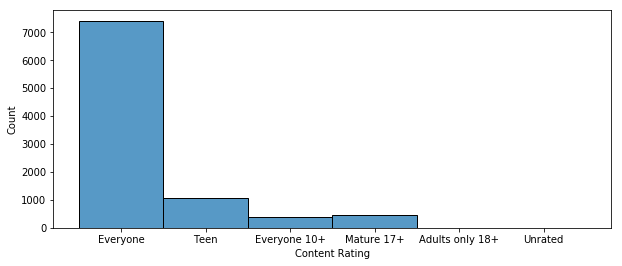

In [32]:
plt.figure(figsize=(10,4))
sns.histplot(x='Content Rating', data=playstore)
plt.show()

In [33]:
playstore['Installs'].unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000,000,000+', '1,000+', '500,000,000+', '100+', '500+', '10+',
       '5+', '50+', '1+'], dtype=object)

In [34]:
len(playstore['Category'].unique())
# len(playstore['Genres'].unique())

33